In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

/Users/jasminecjwchen/Documents/GitHub/COMS4995-AML-Project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math

In [101]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import LabelEncoder
from sklearn.metrics import roc_auc_score

In [4]:
from scikeras.wrappers import KerasClassifier

In [5]:
%matplotlib inline
sns.set_theme()

In [6]:
df = pd.read_csv("kaggle_survey_2020_responses.csv")

In [7]:
salary_data = df.drop(columns = ["time_from_start_to_finish_seconds"])

In [8]:
salary_data = salary_data.dropna(subset = ["q24"])

In [9]:
salary_data_as_num = pd.DataFrame()

In [10]:
def convert_to_category(col_name: str, order_rules: list, data):
    data[col_name] = pd.Categorical(data[col_name], order_rules)

In [11]:
def convert_to_category_no_specified_order(col_name, data):
    if sum(data[col_name].isna().astype(int)) > 0:
        data[col_name].fillna("No response", inplace = True)
    
    order = list(set(data[col_name]))
    convert_to_category(col_name, order, data)

In [12]:
def convert_category_to_code(col_name: str, data, inplace = False):
    if inplace:
        data[col_name] = data[col_name].cat.codes + 1 # because NaN automatically becomes -1
    else:
        return data[col_name].cat.codes + 1

In [13]:
def process_column(col_name: str, order_rules = None, data = salary_data, num_data = salary_data_as_num):
    if order_rules:
        convert_to_category(col_name, order_rules, data)
    else:
        convert_to_category_no_specified_order(col_name, data)
    num_data[col_name] = convert_category_to_code(col_name, data)

In [14]:
def one_hot_column_to_binary(col_name, data = salary_data):
    data[col_name].fillna(0, inplace = True)
    data[col_name].mask(data[col_name] != 0, 1, inplace = True)

In [15]:
def process_one_hot_encoded_columns(columns, data = salary_data, num_data = salary_data_as_num):
    for col in columns:
        one_hot_column_to_binary(col, data)
        num_data[col] = data[col]

In [16]:
def column_text_to_binary(col_name, data = salary_data, num_data = salary_data_as_num):
    data[col_name] = data[col_name].notna().astype(int)
    num_data[col_name] = data[col_name]

In [17]:
def combine_multiple_columns_into_one_binary(columns, new_col_name, data = salary_data, num_data = salary_data_as_num):
    for col_name in columns:
        one_hot_column_to_binary(col_name)
        
    data[new_col_name] = data[columns].sum(axis = 1)
    data[new_col_name] = data[new_col_name].astype(int)
    
    data[new_col_name].mask(data[new_col_name] > 0, 1, inplace = True)
    num_data[new_col_name] = data[new_col_name]

## Q24 Target Column

### v1: original bins

In [18]:
q24_order = ["$0-999",
             '1,000-1,999',
             '2,000-2,999',
             '3,000-3,999',
             '4,000-4,999',
             '5,000-7,499',
             '7,500-9,999',
             '10,000-14,999',
             '15,000-19,999',
             '20,000-24,999',
             '25,000-29,999',
             '30,000-39,999',
             '40,000-49,999',
             '50,000-59,999',
              '60,000-69,999',
              '70,000-79,999',
              '80,000-89,999',
              '90,000-99,999',
            '100,000-124,999',
            '125,000-149,999',
            '150,000-199,999',
             '200,000-249,999',
             '250,000-299,999',
              '300,000-500,000',
              '> $500,000'
             ]

## v2: numerical

In [19]:
q24_mapped_to = [
    1, #"$0-999",
    1, #        '1,000-1,999',
    1, #         '2,000-2,999',
    1, #         '3,000-3,999',
    1, #         '4,000-4,999',
    1, #        '5,000-7,499',
    1, #         '7,500-9,999',
    2, #         '10,000-14,999',
    2, #         '15,000-19,999',
    2, #         '20,000-24,999',
    2, #         '25,000-29,999',
    2, #         '30,000-39,999',
    2, #         '40,000-49,999',
    2, #         '50,000-59,999',
    2, #          '60,000-69,999',
    2, #          '70,000-79,999',
    2, #          '80,000-89,999',
    2, #          '90,000-99,999',
    3, #        '100,000-124,999',
    3, #        '125,000-149,999',
    3, #        '150,000-199,999',
    3, #         '200,000-249,999',
    3, #         '250,000-299,999',
    3, #          '300,000-500,000',
    4 #          '> $500,000'
]

In [20]:
q24_mapping = dict(zip(q24_order, q24_mapped_to))

In [21]:
test_col = salary_data["q24"].copy()
test_col

1        100,000-124,999
2          15,000-19,999
3        125,000-149,999
8          70,000-79,999
11         30,000-39,999
              ...       
20024        2,000-2,999
20029      15,000-19,999
20033             $0-999
20034             $0-999
20035             $0-999
Name: q24, Length: 10729, dtype: object

In [22]:
test_col = test_col.replace(q24_mapping)

In [23]:
salary_data["q24"] = test_col
salary_data_as_num["q24"] = test_col

## Q1 Age

In [24]:
salary_data["q1"].value_counts()

q1
25-29    2350
30-34    1979
35-39    1467
22-24    1424
40-44    1042
45-49     771
50-54     536
18-21     498
60-69     309
55-59     301
70         52
Name: count, dtype: int64

In [25]:
q1_order = [
    "18-21",
    "22-24",
    "25-29",
    "30-34",
    "35-39",
    "40-44",
    "45-49",
    "50-54",
    "55-59",
    "60-69",
    "70"
]

In [26]:
convert_to_category("q1", q1_order, salary_data)

In [27]:
salary_data_as_num["q1"] = convert_category_to_code("q1", salary_data, False)
salary_data_as_num

,q24,q1
1,3,4
2,2,5
3,3,4
8,2,5
11,2,5
...,...,...
20024,1,5
20029,2,5
20033,1,4
20034,1,2


In [28]:
salary_data_as_num["q1"].value_counts()

q1
3     2350
4     1979
5     1467
2     1424
6     1042
7      771
8      536
1      498
10     309
9      301
11      52
Name: count, dtype: int64

## Q2 Gender

In [29]:
salary_data["q2"].value_counts()

q2
Man                        8872
Woman                      1683
Prefer not to say           131
Prefer to self-describe      23
Nonbinary                    20
Name: count, dtype: int64

In [30]:
q2_order = ['Man', "Woman", "Nonbinary", 'Prefer to self-describe', 'Prefer not to say']

In [31]:
convert_to_category("q2", q2_order, salary_data)

In [32]:
salary_data_as_num["q2"] = convert_category_to_code("q2", salary_data, False)
salary_data_as_num

,q24,q1,q2
1,3,4,1
2,2,5,1
3,3,4,1
8,2,5,1
11,2,5,1
...,...,...,...
20024,1,5,1
20029,2,5,1
20033,1,4,1
20034,1,2,1


In [33]:
salary_data_as_num["q2"].value_counts()

q2
1    8872
2    1683
5     131
4      23
3      20
Name: count, dtype: int64

## Q3 Country

In [34]:
convert_to_category_no_specified_order("q3", salary_data)

In [35]:
salary_data_as_num["q3"] = convert_category_to_code("q3", salary_data)

## Q4 Education

In [36]:
salary_data["q4"].value_counts()

q4
Master’s degree                                                      4879
Bachelor’s degree                                                    3013
Doctoral degree                                                      1718
Professional degree                                                   470
Some college/university study without earning a bachelor’s degree     385
I prefer not to answer                                                158
No formal education past high school                                  106
Name: count, dtype: int64

In [37]:
q4_order = ["No formal education past high school",
            "Some college/university study without earning a bachelor’s degree",
            "Professional degree",
            "Bachelor’s degree",
            "Master’s degree",
            "Doctoral degree",
            "I prefer not to answer"
            ]

In [38]:
convert_to_category("q4", q4_order, salary_data)

In [39]:
salary_data_as_num["q4"] = convert_category_to_code("q4", salary_data)

In [40]:
salary_data_as_num["q4"].value_counts()

q4
5    4879
4    3013
6    1718
3     470
2     385
7     158
1     106
Name: count, dtype: int64

## Q5 Job Title

In [41]:
salary_data["q5"].value_counts()

q5
Data Scientist               2398
Software Engineer            1620
Other                        1508
Data Analyst                 1260
Research Scientist           1028
Machine Learning Engineer     918
Business Analyst              678
Product/Project Manager       590
Data Engineer                 369
Statistician                  248
DBA/Database Engineer         112
Name: count, dtype: int64

In [42]:
convert_to_category_no_specified_order("q5", salary_data)

In [43]:
salary_data_as_num["q5"] = convert_category_to_code("q5", salary_data)

## Q6 Years Coding

In [44]:
q6_order = [
 'I have never written code',
 '< 1 years',
 '1-2 years',
 '3-5 years',
 '5-10 years',
 '10-20 years',
 '20+ years']

In [45]:
process_column("q6", q6_order)

## Q7 Language

In [46]:
q7_columns = [
     'q7_part_1',
 'q7_part_2',
 'q7_part_3',
 'q7_part_4',
 'q7_part_5',
 'q7_part_6',
 'q7_part_7',
 'q7_part_8',
 'q7_part_9',
 'q7_part_10',
 'q7_part_11',
 'q7_part_12',
 'q7_other'
]

In [47]:
process_one_hot_encoded_columns(q7_columns)

## Q11 Computing Platform

In [48]:
process_column("q11")

## Q12 Specialized Hardware

In [49]:
q12_columns = [
    'q12_part_1',
 'q12_part_2',
 'q12_part_3',
 'q12_other'
]

In [50]:
process_one_hot_encoded_columns(q12_columns)

## Q14 Visualization

In [51]:
q14_columns = [
    'q14_part_1',
 'q14_part_2',
 'q14_part_3',
 'q14_part_4',
 'q14_part_5',
 'q14_part_6',
 'q14_part_7',
 'q14_part_8',
 'q14_part_9',
 'q14_part_10',
 'q14_part_11',
 'q14_other'
]

In [52]:
process_one_hot_encoded_columns(q14_columns)

## Q15 Years ML

In [53]:
q15_order = [
    'I do not use machine learning methods',
    'Under 1 year',
    '1-2 years',
    '2-3 years',
    '3-4 years',
    '4-5 years',
    '5-10 years',
    '10-20 years',
    '20 or more years'
]

In [54]:
process_column("q15", q15_order)

## Q17 ML Algorithms

In [55]:
q17_columns = [
    'q17_part_1',
 'q17_part_2',
 'q17_part_3',
 'q17_part_4',
 'q17_part_5',
 'q17_part_6',
 'q17_part_7',
 'q17_part_8',
 'q17_part_9',
 'q17_part_10',
 'q17_part_11',
 'q17_other'
]

In [56]:
process_one_hot_encoded_columns(q17_columns)

## Q20 Company Size

In [57]:
q20_order = [
    '0-49 employees',
    '50-249 employees',
    '250-999 employees',
    '1000-9,999 employees',
    '10,000 or more employees'
]

In [58]:
process_column("q20", q20_order)

## Q21 Datascience Workloads

In [59]:
q21_order = [
    '0',
    '1-2',
    '3-4',
    '5-9',
    '10-14',
    '15-19',
    '20'
]

In [60]:
process_column("q21", q21_order)

## Q22 Incorporating ML

i'm not super sure about the proper "order" for this question. Feel free to change this if you find it more appropriate. Just please let the chat know in case it affects others' encoding.

In [61]:
q22_order = [
    'I do not know',
    'No (we do not use ML methods)',
    'We are exploring ML methods (and may one day put a model into production)',
    'We use ML methods for generating insights (but do not put working models into production)',
    'We recently started using ML methods (i.e., models in production for less than 2 years)',
    'We have well established ML methods (i.e., models in production for more than 2 years)'
]

In [62]:
process_column("q22", q22_order)

## Q30 Big Data Products

In [63]:
column_text_to_binary("q30")

## Q32 Business Intelligence Tools

In [64]:
column_text_to_binary("q32")

## Q33 Automated ML Tools

In [65]:
q33_columns = [
    'q33_a_part_1',
 'q33_a_part_2',
 'q33_a_part_3',
 'q33_a_part_4',
 'q33_a_part_5',
 'q33_a_part_6',
 'q33_a_part_7',
 'q33_a_other'
]

In [66]:
combine_multiple_columns_into_one_binary(q33_columns, "q33")

## Q37 Data Science Courses

In [67]:
q37_columns = [
    'q37_part_1',
 'q37_part_2',
 'q37_part_3',
 'q37_part_4',
 'q37_part_5',
 'q37_part_6',
 'q37_part_7',
 'q37_part_8',
 'q37_part_9',
 'q37_part_10',
 'q37_part_11',
 'q37_other'
]

In [68]:
process_one_hot_encoded_columns(q37_columns)

## Q38 Primary Data Analysis Tool

In [69]:
process_column("q38")

## Q39 Media Sources

In [70]:
q39_columns = [
    'q39_part_1',
 'q39_part_2',
 'q39_part_3',
 'q39_part_4',
 'q39_part_5',
 'q39_part_6',
 'q39_part_7',
 'q39_part_8',
 'q39_part_9',
 'q39_part_10',
 'q39_part_11',
 'q39_other'
]

In [71]:
process_one_hot_encoded_columns(q39_columns)

## Dropped Columns

In [72]:
one_hot_dropped = [
    'q33_a_part_1',
 'q33_a_part_2',
 'q33_a_part_3',
 'q33_a_part_4',
 'q33_a_part_5',
 'q33_a_part_6',
 'q33_a_part_7',
 'q33_a_other',
]

In [73]:
dropped_questions = [
    "q8",
    'q9_part_1',
 'q9_part_2',
 'q9_part_3',
 'q9_part_4',
 'q9_part_5',
 'q9_part_6',
 'q9_part_7',
 'q9_part_8',
 'q9_part_9',
 'q9_part_10',
 'q9_part_11',
 'q9_other',
 'q10_part_1',
 'q10_part_2',
 'q10_part_3',
 'q10_part_4',
 'q10_part_5',
 'q10_part_6',
 'q10_part_7',
 'q10_part_8',
 'q10_part_9',
 'q10_part_10',
 'q10_part_11',
 'q10_part_12',
 'q10_part_13',
 'q10_other',
 "q13",
 'q16_part_1',
 'q16_part_2',
 'q16_part_3',
 'q16_part_4',
 'q16_part_5',
 'q16_part_6',
 'q16_part_7',
 'q16_part_8',
 'q16_part_9',
 'q16_part_10',
 'q16_part_11',
 'q16_part_12',
 'q16_part_13',
 'q16_part_14',
 'q16_part_15',
 'q16_other',
 'q18_part_1',
 'q18_part_2',
 'q18_part_3',
 'q18_part_4',
 'q18_part_5',
 'q18_part_6',
 'q18_other',
 'q19_part_1',
 'q19_part_2',
 'q19_part_3',
 'q19_part_4',
 'q19_part_5',
 'q19_other',
 'q23_part_1',
 'q23_part_2',
 'q23_part_3',
 'q23_part_4',
 'q23_part_5',
 'q23_part_6',
 'q23_part_7',
 'q23_other',
 'q25',
 'q26_a_part_1',
 'q26_a_part_2',
 'q26_a_part_3',
 'q26_a_part_4',
 'q26_a_part_5',
 'q26_a_part_6',
 'q26_a_part_7',
 'q26_a_part_8',
 'q26_a_part_9',
 'q26_a_part_10',
 'q26_a_part_11',
 'q26_a_other',
 'q27_a_part_1',
 'q27_a_part_2',
 'q27_a_part_3',
 'q27_a_part_4',
 'q27_a_part_5',
 'q27_a_part_6',
 'q27_a_part_7',
 'q27_a_part_8',
 'q27_a_part_9',
 'q27_a_part_10',
 'q27_a_part_11',
 'q27_a_other',
 'q28_a_part_1',
 'q28_a_part_2',
 'q28_a_part_3',
 'q28_a_part_4',
 'q28_a_part_5',
 'q28_a_part_6',
 'q28_a_part_7',
 'q28_a_part_8',
 'q28_a_part_9',
 'q28_a_part_10',
 'q28_a_other',
 'q29_a_part_1',
 'q29_a_part_2',
 'q29_a_part_3',
 'q29_a_part_4',
 'q29_a_part_5',
 'q29_a_part_6',
 'q29_a_part_7',
 'q29_a_part_8',
 'q29_a_part_9',
 'q29_a_part_10',
 'q29_a_part_11',
 'q29_a_part_12',
 'q29_a_part_13',
 'q29_a_part_14',
 'q29_a_part_15',
 'q29_a_part_16',
 'q29_a_part_17',
 'q29_a_other',
 'q31_a_part_1',
 'q31_a_part_2',
 'q31_a_part_3',
 'q31_a_part_4',
 'q31_a_part_5',
 'q31_a_part_6',
 'q31_a_part_7',
 'q31_a_part_8',
 'q31_a_part_9',
 'q31_a_part_10',
 'q31_a_part_11',
 'q31_a_part_12',
 'q31_a_part_13',
 'q31_a_part_14',
 'q31_a_other',
 'q34_a_part_1',
 'q34_a_part_2',
 'q34_a_part_3',
 'q34_a_part_4',
 'q34_a_part_5',
 'q34_a_part_6',
 'q34_a_part_7',
 'q34_a_part_8',
 'q34_a_part_9',
 'q34_a_part_10',
 'q34_a_part_11',
 'q34_a_other',
 'q35_a_part_1',
 'q35_a_part_2',
 'q35_a_part_3',
 'q35_a_part_4',
 'q35_a_part_5',
 'q35_a_part_6',
 'q35_a_part_7',
 'q35_a_part_8',
 'q35_a_part_9',
 'q35_a_part_10',
 'q35_a_other',
 'q36_part_1',
 'q36_part_2',
 'q36_part_3',
 'q36_part_4',
 'q36_part_5',
 'q36_part_6',
 'q36_part_7',
 'q36_part_8',
 'q36_part_9',
 'q36_other',
]

In [74]:
part_b_dropped = [
    'q26_b_part_1',
 'q26_b_part_2',
 'q26_b_part_3',
 'q26_b_part_4',
 'q26_b_part_5',
 'q26_b_part_6',
 'q26_b_part_7',
 'q26_b_part_8',
 'q26_b_part_9',
 'q26_b_part_10',
 'q26_b_part_11',
 'q26_b_other',
 'q27_b_part_1',
 'q27_b_part_2',
 'q27_b_part_3',
 'q27_b_part_4',
 'q27_b_part_5',
 'q27_b_part_6',
 'q27_b_part_7',
 'q27_b_part_8',
 'q27_b_part_9',
 'q27_b_part_10',
 'q27_b_part_11',
 'q27_b_other',
 'q28_b_part_1',
 'q28_b_part_2',
 'q28_b_part_3',
 'q28_b_part_4',
 'q28_b_part_5',
 'q28_b_part_6',
 'q28_b_part_7',
 'q28_b_part_8',
 'q28_b_part_9',
 'q28_b_part_10',
 'q28_b_other',
 'q29_b_part_1',
 'q29_b_part_2',
 'q29_b_part_3',
 'q29_b_part_4',
 'q29_b_part_5',
 'q29_b_part_6',
 'q29_b_part_7',
 'q29_b_part_8',
 'q29_b_part_9',
 'q29_b_part_10',
 'q29_b_part_11',
 'q29_b_part_12',
 'q29_b_part_13',
 'q29_b_part_14',
 'q29_b_part_15',
 'q29_b_part_16',
 'q29_b_part_17',
 'q29_b_other',
 'q31_b_part_1',
 'q31_b_part_2',
 'q31_b_part_3',
 'q31_b_part_4',
 'q31_b_part_5',
 'q31_b_part_6',
 'q31_b_part_7',
 'q31_b_part_8',
 'q31_b_part_9',
 'q31_b_part_10',
 'q31_b_part_11',
 'q31_b_part_12',
 'q31_b_part_13',
 'q31_b_part_14',
 'q31_b_other',
 'q33_b_part_1',
 'q33_b_part_2',
 'q33_b_part_3',
 'q33_b_part_4',
 'q33_b_part_5',
 'q33_b_part_6',
 'q33_b_part_7',
 'q33_b_other',
 'q34_b_part_1',
 'q34_b_part_2',
 'q34_b_part_3',
 'q34_b_part_4',
 'q34_b_part_5',
 'q34_b_part_6',
 'q34_b_part_7',
 'q34_b_part_8',
 'q34_b_part_9',
 'q34_b_part_10',
 'q34_b_part_11',
 'q34_b_other',
 'q35_b_part_1',
 'q35_b_part_2',
 'q35_b_part_3',
 'q35_b_part_4',
 'q35_b_part_5',
 'q35_b_part_6',
 'q35_b_part_7',
 'q35_b_part_8',
 'q35_b_part_9',
 'q35_b_part_10',
 'q35_b_other'
]

In [75]:
salary_data = salary_data.drop(columns = one_hot_dropped)

In [76]:
salary_data = salary_data.drop(columns = part_b_dropped)

In [77]:
salary_data_selected_questions = salary_data.drop(columns = dropped_questions)

# DNN Model

In [78]:
X = salary_data_as_num.drop(columns = ["q24"])
y = salary_data_as_num["q24"]

In [79]:
y

1        3
2        2
3        3
8        2
11       2
        ..
20024    1
20029    2
20033    1
20034    1
20035    1
Name: q24, Length: 10729, dtype: int64

In [80]:
x_dev, x_test, y_dev, y_test = train_test_split(X, y, test_size = 0.2, random_state = 6)

In [81]:
x_dev = tf.convert_to_tensor(x_dev.astype("int64"))
x_test = tf.convert_to_tensor(x_test.astype("int64"))
y_dev = tf.convert_to_tensor(y_dev.astype("int64"))
y_test = tf.convert_to_tensor(y_test.astype("int64"))

2023-12-08 23:56:08.637355: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-08 23:56:08.637395: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-08 23:56:08.637403: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-08 23:56:08.637630: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-08 23:56:08.638000: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [111]:
class DNN:
    
    def __init__(self, x_dev = x_dev, y_dev = y_dev, x_test = x_test, y_test = y_test):
        self.x_dev = x_dev
        self.y_dev = y_dev
        self.x_test = x_test
        self.y_test = y_test
        
        self.layers = [Dense(32, input_shape = (80, ), activation = "relu")]
        
        self.optimizer = "adam"
        self.loss = "sparse_categorical_crossentropy"
        self.metrics =  ["accuracy"]
        
        self.batch_size = 100
        self.epochs = 50
        
    def customize_first_layer(self, node_count = 32):
        self.layers = [Dense(node_count, input_shape = (80, ), activation = "relu")]
        
    def add_one_dense_layer(self, node_count = 32):
        self.layers.append(Dense(node_count, activation = "relu"))
        
    def customize_middle_layers(self, layers):
        self.layers.extend(layers)
    
    def customize_compile(self,
                          optimizer = "adam",
                          loss = "sparse_categorical_crossentropy",
                          metrics = ["accuracy"]):
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics
    
    def customize_fit(self,
                      batch_size = 100,
                      epochs = 50
                      ):
        self.batch_size = batch_size
        self.epochs = epochs
    
    def build_compile_and_evaluate(self, metric_to_return = "accuracy", selection_criteria = max):
        # final layer must be softmax and outputs 4
        self.layers.append(Dense(4, activation = "softmax"))
        
        self.model = Sequential(self.layers)
        self.model.compile(optimizer = self.optimizer,
                      loss = self.loss,
                      metrics = self.metrics)
        fit_history = self.model.fit(self.x_dev, self.y_dev,
                                batch_size = self.batch_size,
                                epochs = self.epochs,
                                validation_split = 0.2,
                                verbose = 1
                                )
        self.fit_history = pd.DataFrame(fit_history.history)
        return selection_criteria(self.fit_history[metric_to_return])
    
    def get_model_summary(self):
        self.model.summary()
        
    def get_fit_history(self):
        return self.fit_history
        
    def evaluate_model_with_test(self):
        return self.model.evaluate(self.x_test, self.y_test, verbose = 0)
    
    def evaluate_model_with_roc_auc(self):
        pred_prob = self.model.predict(self.x_test)
        return roc_auc_score(y_test, pred_prob, average = "weighted", multi_class = "ovr")

In [112]:
d = DNN()
d.customize_fit(epochs = 2)
d.add_one_dense_layer()
d.build_compile_and_evaluate()

Epoch 1/2
69/69 [==============================] - 5s 16ms/step - loss: 1.8792 - accuracy: 0.4040 - val_loss: 1.2666 - val_accuracy: 0.4467
Epoch 2/2
69/69 [==============================] - 1s 9ms/step - loss: 1.1687 - accuracy: 0.4834 - val_loss: 1.0517 - val_accuracy: 0.5358


0.4833964407444

## Single Layer Width

In [113]:
results = []

for i in range(10):
    layer_width = 2 ** i
    print("---- building model for layer width of " + str(layer_width))
    d = DNN()
    d.customize_first_layer(layer_width)
    
    #d.customize_fit(epochs = 2) ## TODO: REMOVE
    
    val_acc_result = d.build_compile_and_evaluate()
    test_loss, test_accuracy = d.evaluate_model_with_test()
    test_roc_auc = d.evaluate_model_with_roc_auc()
    
    results.append((layer_width, val_acc_result, "Validation Accuracy"))
    results.append((layer_width, test_loss, "Test Loss"))
    results.append((layer_width, test_accuracy, "Test Accuracy"))
    results.append((layer_width, test_roc_auc, "Test ROC-AUC Score"))
    
results = pd.DataFrame(results)
results = results.rename(columns = {
    0: "Layer Width",
    1: "Metrics Value",
    2: "Metrics Type"
})
results

---- building model for layer width of 1
Epoch 1/50
69/69 [==============================] - 1s 12ms/step - loss: 1.5832 - accuracy: 0.2929 - val_loss: 1.5513 - val_accuracy: 0.2405
Epoch 2/50
69/69 [==============================] - 0s 7ms/step - loss: 1.4946 - accuracy: 0.2757 - val_loss: 1.4159 - val_accuracy: 0.3128
Epoch 3/50
69/69 [==============================] - 1s 8ms/step - loss: 1.3377 - accuracy: 0.3705 - val_loss: 1.2365 - val_accuracy: 0.4316
Epoch 4/50
69/69 [==============================] - 1s 9ms/step - loss: 1.1891 - accuracy: 0.4314 - val_loss: 1.1317 - val_accuracy: 0.4508
Epoch 5/50
69/69 [==============================] - 0s 7ms/step - loss: 1.1004 - accuracy: 0.4442 - val_loss: 1.0637 - val_accuracy: 0.4485
Epoch 6/50
69/69 [==============================] - 0s 7ms/step - loss: 1.0462 - accuracy: 0.4461 - val_loss: 1.0254 - val_accuracy: 0.4496
Epoch 7/50
69/69 [==============================] - 1s 7ms/step - loss: 1.0182 - accuracy: 0.4518 - val_loss: 1.0087 -

,Layer Width,Metrics Value,Metrics Type
0,1,0.614768,Validation Accuracy
1,1,0.838767,Test Loss
2,1,0.601118,Test Accuracy
3,1,0.597288,Test ROC-AUC Score
4,2,0.469415,Validation Accuracy
5,2,0.983864,Test Loss
6,2,0.457130,Test Accuracy
7,2,0.542819,Test ROC-AUC Score
8,4,0.620012,Validation Accuracy
9,4,0.822589,Test Loss


In [114]:
accuracy_only = results[(results["Metrics Type"] == "Test Accuracy") | (results["Metrics Type"] == "Validation Accuracy")]
accuracy_only

,Layer Width,Metrics Value,Metrics Type
0,1,0.614768,Validation Accuracy
2,1,0.601118,Test Accuracy
4,2,0.469415,Validation Accuracy
6,2,0.457130,Test Accuracy
8,4,0.620012,Validation Accuracy
10,4,0.595061,Test Accuracy
12,8,0.621177,Validation Accuracy
14,8,0.612302,Test Accuracy
16,16,0.627148,Validation Accuracy
18,16,0.607176,Test Accuracy


<Axes: xlabel='Layer Width', ylabel='Metrics Value'>

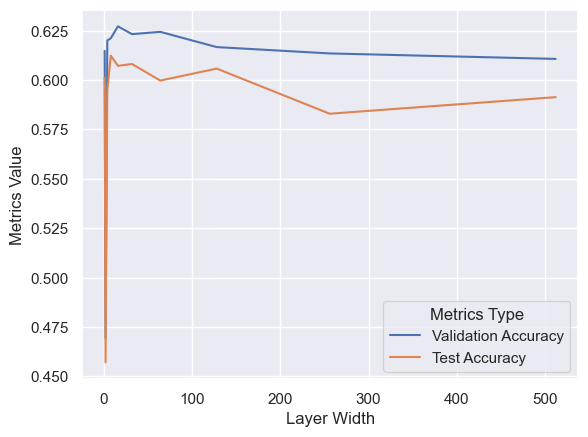

In [115]:
sns.lineplot(accuracy_only, 
             x = "Layer Width",
             y = "Metrics Value",
             hue = "Metrics Type"
             )

In [121]:
roc_auc_only = results[results["Metrics Type"] == "Test ROC-AUC Score"]
roc_auc_only

,Layer Width,Metrics Value,Metrics Type
3,1,0.597288,Test ROC-AUC Score
7,2,0.542819,Test ROC-AUC Score
11,4,0.466887,Test ROC-AUC Score
15,8,0.551681,Test ROC-AUC Score
19,16,0.504223,Test ROC-AUC Score
23,32,0.472552,Test ROC-AUC Score
27,64,0.514470,Test ROC-AUC Score
31,128,0.523959,Test ROC-AUC Score
35,256,0.486863,Test ROC-AUC Score
39,512,0.476232,Test ROC-AUC Score


<Axes: xlabel='Layer Width', ylabel='Metrics Value'>

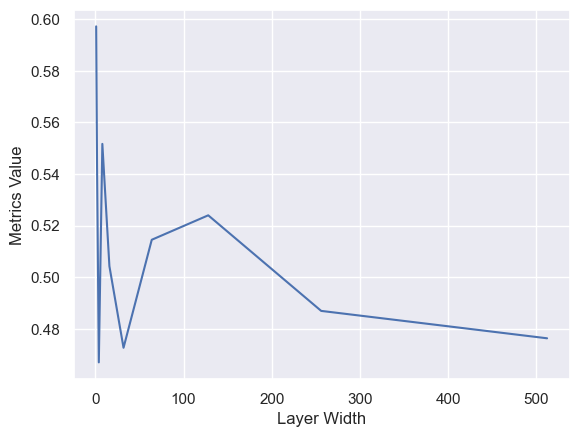

In [122]:
sns.lineplot(roc_auc_only, 
             x = "Layer Width",
             y = "Metrics Value"
             )